In [9]:
import math
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers

In [10]:
class Data:
    def __init__(self, field='Close', ratio=0.8, stock='AAPL', start='2016-01-01', end='2022-10-01'):
        self.test_data_x = None
        self.test_data_y = None
        self.test_data = None
        self.train_data_x = None
        self.train_data_y = None
        self.train_data = None
        self.normalized_data = None
        self.field_data = None
        self.data = None
        self.field = field
        self.ratio = ratio
        self.stock = stock
        self.start = start
        self.end = end
        self.download_all_data()
        self.download_field_data()
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.normalize_data(self.field_data)
        self.train_data_length = math.ceil(self.ratio * len(self.field_data))
        self.split_data()

    def download_all_data(self):
        self.data = yf.download(self.stock, start=self.start, end=self.end)

    def download_field_data(self):
        self.field_data = yf.download(self.stock, start=self.start, end=self.end)[self.field]

    def plot_data(self):
        plt.figure(figsize=(15, 8))
        plt.title('Stock Prices History')
        plt.plot(self.field_data)
        plt.xlabel('Date')
        plt.ylabel('Prices ($)')

    def normalize_data(self, data):
        values = data.values
        self.normalized_data = self.scaler.fit_transform(values.reshape(-1, 1))

    def split_data(self):
        self.train_data = self.normalized_data[0: self.train_data_length, :]
        self.train_data_x = np.array([self.train_data[i - 60: i, 0] for i in range(60, len(self.train_data))])
        self.train_data_y = np.array([self.train_data[i] for i in range(len(self.train_data))])

        self.train_data_x = np.reshape(self.train_data_x, (self.train_data_x.shape[0], self.train_data_x.shape[1], 1))

        self.test_data = self.normalized_data[self.train_data_length - 60:, :]
        self.test_data_x = np.array([self.test_data[i - 60: i, 0] for i in range(60, len(self.test_data))])
        self.test_data_y = np.array(self.field_data.values[self.train_data_length:])

        self.test_data_x = np.reshape(self.test_data_x, (self.test_data_x.shape[0], self.test_data_x.shape[1], 1))

    def denormalize_data(self, data):
        return self.scaler.inverse_transform(data)

In [11]:
class Model:
    def __init__(self, train_data_x, train_data_y, test_data_x, test_data_y,
                 optimizer='adam', loss='mae', epochs=20, batch_size=10):
        self.accuracy = None
        self.predictions = None
        self.model = None
        self.train_data_x = train_data_x
        self.train_data_y = train_data_y
        self.test_data_x = test_data_x
        self.test_data_y = test_data_y
        self.optimizer = optimizer
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.define_model()

    def define_model(self):
        self.model = keras.Sequential()
        self.model.add(layers.LSTM(100, return_sequences=True, input_shape=(self.train_data_x.shape[1], 1)))
        self.model.add(layers.LSTM(100, return_sequences=False))
        self.model.add(layers.Dense(25))
        self.model.add(layers.Dense(1))
        self.model.compile(optimizer=self.optimizer, loss=self.loss)

    def load_model(self):
        self.model.load_weights('Model' + str(self.batch_size) + '_' + str(self.epochs) + '_' + str(self.optimizer) + '_' + str(self.loss) + '.h5')

    def fit_and_save_model(self):
        self.model.fit(self.train_data_x, self.train_data_y, batch_size=self.batch_size, epochs=self.epochs)
        self.model.save_weights('Model' + str(self.batch_size) + '_' + str(self.epochs) + '_' + str(self.optimizer) + '_' + str(self.loss) + '.h5')

    def predict(self):
        self.predictions = self.model.predict(self.test_data_x)

    def compute_metrics(self, data, predictions, train_data_length):
        validation = data[train_data_length :]
        total = len(validation)
        correct = 0
        for i in range(total - 1):
            if validation[i] - 0.05 * validation[i] <= predictions[i] <= validation[i] + 0.05 * validation[i]:
                correct = correct + 1
        self.accuracy = correct / total

In [12]:
def predict(model, x_test, scaler):
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [13]:
def plotResult(stock_data, predictions, training_data_len):
    data = stock_data.filter(['Close'])
    validation = data[training_data_len :]
    validation['Predictions'] = predictions
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(validation[['Close', 'Predictions']])
    plt.legend(['Val', 'Predictions'], loc='lower right')
    plt.show()

In [14]:
def accuracy(data, predictions, training_data_len):
    validation = data[training_data_len :]
    total = len(validation)
    correct = 0
    for i in range(total - 1):
        if validation[i] - 0.05 * validation[i] <= predictions[i] <= validation[i] + 0.05 * validation[i]:
            correct = correct + 1
    return correct / total

In [15]:
def main():
    data = Data()
    model = Model(data.train_data_x, data.train_data_y, data.test_data_x, data.test_data_y)
    model.load_model()
    model.predict()
    predictions = data.denormalize_data(model.predictions)
    plotResult(data.data, predictions, data.train_data_length)
    model.compute_metrics(data.field_data, predictions, data.train_data_length)
    print(model.accuracy)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
11/11 [==============================] - 1s 17ms/step


/var/folders/s1/klxd2l7x5cq5m83phzf1lk7m0000gn/T/ipykernel_4669/2918058859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


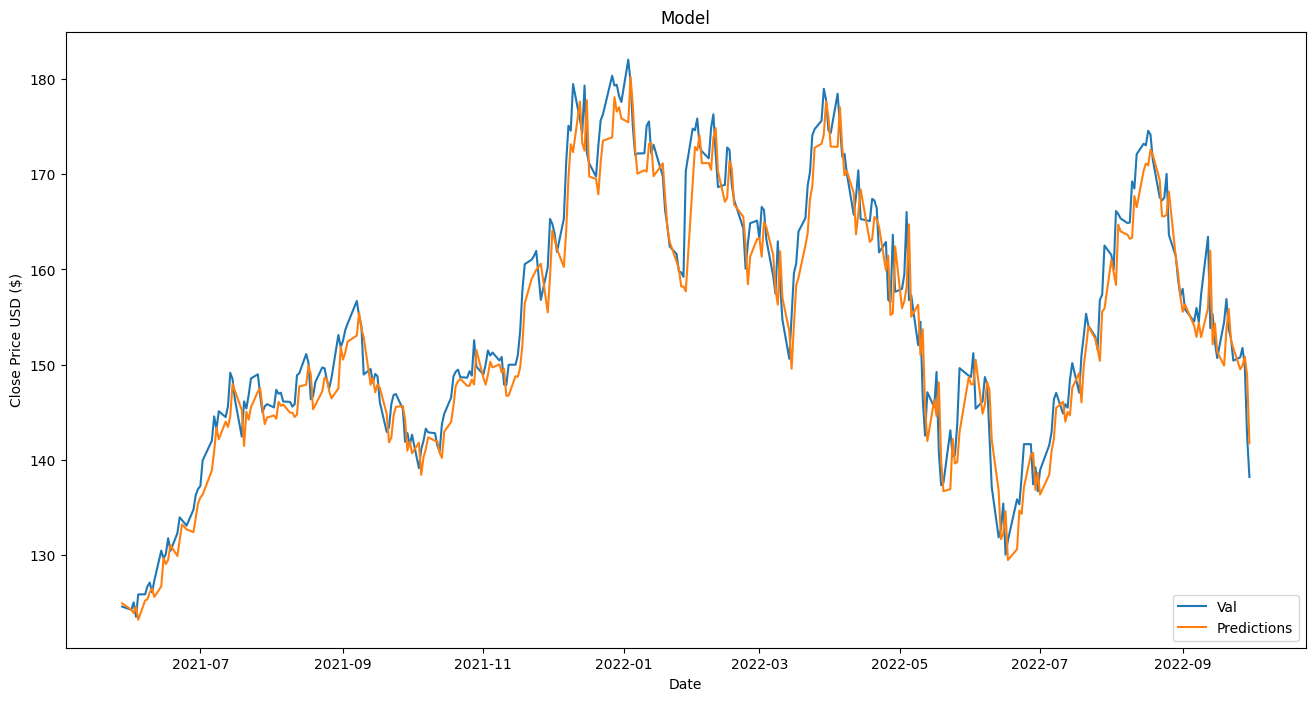

0.9823008849557522


In [16]:
main()